Enter Path to the folder you wish to process:

In [1]:
# mainFolder = "/data/Sandra/2019/"
mainFolder = "/data/MB2020_lifs/2012/"

In [2]:
## This is where yu specify where it should attempt to merge series which come sequentially
merge = False

In [3]:
## importing stuff
import os
import pickle
from sys import path as syspath
syspath.append(os.path.expanduser("~/srdjan_functs/"))
import javabridge
from bioformats import JARS as bfJARS
javabridge.start_vm(class_path=bfJARS, max_heap_size="6G")
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2
# %aimport islets

from IPython.display import display

import pandas as pd

from islets.Recording import Recording, saveMovie
from islets.Regions import Regions
from islets.numeric import power_spectrum, rebin
from islets.utils import saveRois
from islets.Regions import getPeak2BoundaryDF, getGraph_of_ROIs_to_Merge, mergeBasedOnGraph
from caiman import movie as cmovie
from matplotlib.colors import LogNorm

/opt/tljh/user/envs/physio/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.decomposition.incremental_pca module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.decomposition. Anything that cannot be imported from sklearn.decomposition is now part of the private API.



In [4]:
def get_filterSizes(px):
    base = int(np.ceil(5/px))
    wider = int(np.ceil(base*1.1))
    if wider==base: wider += 1
    toComb = int(np.ceil(base*1.3))
    if toComb <= wider: toComb += 1
    return [(base,), (wider,), (base,wider), (base,toComb)]

def parse_leica(rec, merge=True, skipTags = ["crop","split","frame", "every","half"]):
    from pandas import Timedelta
    toDrop = [i for i,row in rec.metadata.iterrows() if "Series" not in row["Name"] or row["SizeT"]<10 or row["SizeY"]>550]
    for tag in skipTags:
        toDrop += [i for i,row in rec.metadata.iterrows() if tag in row["Name"].lower()]
    rec.metadata.drop(index=np.unique(toDrop), inplace=True)
    if not merge:
        return  list(rec.metadata.Name.values)
    if len(rec.metadata)>1:
        rec.calc_gaps()
        ff = np.any(
                [rec.metadata["gap"]>5]+
                [rec.metadata["gap"]<-5]+
                [rec.metadata[c].diff().abs()>0 for c in ["pxSize", "SizeX", "SizeY"]],
            axis=0)
        sers = np.split(rec.metadata.Name.values, np.where(ff)[0])
    else:
        sers = [rec.metadata.Name.values]
    
    outSer = []
    for serlist in sers:
        if len(serlist)==len(rec.metadata):
            ser="all"
        else:
            serrange = [int(el.replace("Series","")) for el in serlist]
            if len(serrange)>1:
                ser = "Series%03i-%i"%(serrange[0],serrange[-1])
            else:
                ser = "Series%03i"%(serrange[0])
        outSer += [ser]
    return outSer

# from copy import deepcopy

fracSaturTh = .05
# movieFreq = 5
cmap = plt.cm.Greys
cmap.set_bad("lime")

pd.set_option('display.max_rows', 100)

### Preprocess: can take a minute or two (per recording)

In [5]:
recordings = []
for cur,ds,fs in os.walk(mainFolder):
    for f in fs:
        if not (f.endswith(".lif") or f.endswith(".nd2")):
            continue
        path = os.path.join(cur,f)
#         try:
#             month = int(os.path.split(cur)[1].split("_")[1])
            #if month<8: continue
#         except:
#             print ("skipping", f,"in", cur)
#             continue
        recordings += [path]

recordings = sorted(recordings)

In [6]:
status = []
for pathToRecording in recordings:
    print ("#"*20, pathToRecording)
    rec = Recording(pathToRecording)
    recType = "Nikon" if pathToRecording.endswith(".nd2") else "Leica"

    if recType=="Leica":
        sers = parse_leica(rec, merge=merge)
    else:
        sers = ["all"]

    analysisFolder = os.path.join(rec.folder, rec.Experiment+"_analysis")
    if not os.path.isdir(analysisFolder):
        os.makedirs(analysisFolder)
        
    for ser in sers:
        saveDir = os.path.join(analysisFolder, ser)
        try:
            rec.import_series(ser, onlyMeta=True)
            if not os.path.isdir(saveDir):
                print ("creating", saveDir)
                os.makedirs(saveDir)
            removeDir = False
        except:
            print (f"could not import {ser}")
            removeDir = True
        if "every" in ser.lower(): removeDir = True
        if "crop" in ser.lower(): removeDir = True
#         if "every" in ser: removeDir = True
        if removeDir:
            if os.path.isdir(saveDir):
                print ("removing", saveDir)
                for c,d,ffs in os.walk(saveDir):
                    for ff in ffs: 
                        os.remove(os.path.join(c,ff))
                os.removedirs(saveDir,)
            continue
        md = rec.Series[ser]["metadata"]
        md["exp"] = pathToRecording
        md["series"] = ser
        fs = get_filterSizes(md.pxSize)
#         md["filter sizes"] = fs
        movieFilename = os.path.join(saveDir, rec.Experiment+"_"+ser+".mp4")
        md["movie done"] = os.path.isfile(movieFilename)
        if md["movie done"]:
            md["movie size"] = os.path.getsize(movieFilename)
        for k in ["bit depth", "Start time", "End time", "individual Series","Name"]:
            try:    del md[k]
            except: pass
        pklsDone = {}
        for fsize in fs:
            pickleFile = os.path.join(saveDir, ".".join(map(str,fsize))+"_rois.pkl")
            imageFile = os.path.join(saveDir, ".image_"+".".join(map(str,fsize))+".png")
            pickleThere = os.path.isfile(pickleFile)
            imageThere = os.path.isfile(imageFile)
            if pickleThere:
                purge = True
                try:
                    with open(pickleFile,"rb") as f:
                        rr = pickle.load(f)
                    purge = "trace" not in rr.df.columns
                    if not purge: lastGood = pickleFile
                except:
                    purge = True
                if purge:
                    os.remove(pickleFile)
                    if imageThere: os.remove(imageFile)
            pklsDone[fsize] = (pickleThere, os.path.isfile(imageFile))
        md["pickles"] = pklsDone
        md["allDone"] = np.array(list(pklsDone.values())).all() and md["movie done"]
        status += [dict(md.items())]
#     break

status = pd.DataFrame(status)

#################### /data/MB2020_lifs/2012/2012_01_06/Pancreas_Islet_OGB02.lif
#################### /data/MB2020_lifs/2012/2012_01_06/Pancreas_Islet_OGB03.lif
#################### /data/MB2020_lifs/2012/2012_01_13/Pancreas_Islet_OGB05.lif
could not import Series045-046
could not import Series028-029
#################### /data/MB2020_lifs/2012/2012_01_21/Pancreas_Islet_OGB07.lif
#################### /data/MB2020_lifs/2012/2012_01_24/Pancreas_islet_OGB08.lif
#################### /data/MB2020_lifs/2012/2012_01_24/Pancreas_islet_OGB09.lif
#################### /data/MB2020_lifs/2012/2012_01_25/Pancreas_islet_OGB10.lif
#################### /data/MB2020_lifs/2012/2012_01_27/Pancreas_islet_OGB11.lif
#################### /data/MB2020_lifs/2012/2012_01_31/Pancreas_Islet_OGB13.lif
#################### /data/MB2020_lifs/2012/2012_02_02/Pancreas_Islet_OGB14.lif
#################### /data/MB2020_lifs/2012/2012_02_02/Pancreas_Islet_OGB15.lif
#################### /data/MB2020_lifs/2012/2012_02_02/Pan

In [7]:
status["array size"] = status["SizeX"]*status["SizeY"]*status["SizeT"]

In [10]:
status.plot.scatter?

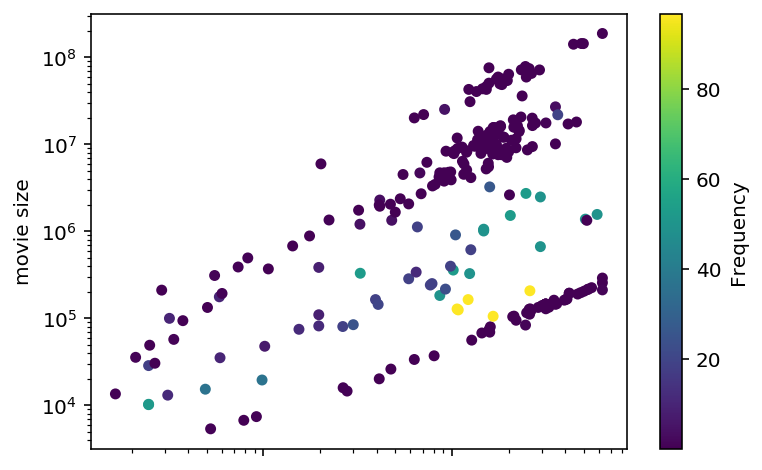

In [13]:
status.plot.scatter(x="array size",y="movie size", c = "Frequency",colormap="viridis")# x="log", yscale="log")
plt.xscale("log")
plt.yscale("log")

In [14]:
# plt.plot(status["SizeX"]*status["SizeY"]*status["SizeT"],status["movie size"]/1e6,".")
# plt.xlabel("array size")
# plt.xlabel("movie size [MB]")
# plt.xscale("log")
# plt.yscale("log")

In [15]:
status.loc[status["movie size"]<2e3,"movie done"] = False
status.loc[status["movie size"]<2e3,"allDone"] = False

In [16]:
firstCols = ["exp", "series","allDone"]
status = status[firstCols+[c for c in status.columns if c not in firstCols]]
toDo = status[~status.allDone]
print (f"{len(status.exp.unique())} recording(s) found.")
print (f"Out of them, {len(toDo.exp.unique())} need to be processed partially or fully.")

39 recording(s) found.
Out of them, 19 need to be processed partially or fully.


#### This is what will be processed:

In [17]:
for exp,df in toDo.groupby("exp"):
    print (f"from {exp}:" )
    display(df[["series", "SizeT", "SizeX", "SizeY", "Frequency","movie done"]])

from /data/MB2020_lifs/2012/2012_03_01/Pancreas_islet_OGB27.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
247,Series005,595,512,512,0.501,True
248,Series009,784,512,512,0.501,False
249,Series016,476,512,512,0.501,False
250,Series020,712,512,512,0.501,False
251,Series024,641,512,512,0.501,False
252,Series028,534,512,512,0.501,False
253,Series032,501,512,512,0.501,False
254,Series036,638,512,512,0.501,False
255,Series041,299,512,512,0.502,False
256,Series047,3528,256,64,18.900,False


from /data/MB2020_lifs/2012/2012_03_06/Pancreas_islet_OGB28.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
294,Series002,515,512,512,0.501,False


from /data/MB2020_lifs/2012/2012_03_06/Pancreas_islet_OGB29.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
295,Series002,466,512,512,0.501,False
296,Series007,519,512,128,0.501,False
297,Series010,70,512,128,0.252,False
298,Series011,7253,256,64,18.900,False
299,Series013,116,512,128,0.251,False
300,Series017,63,512,128,0.253,False
301,Series018,7688,256,64,18.900,False
302,Series020,147,512,128,0.251,False
303,Series025,122,512,128,0.503,False
304,Series026,3062,256,64,18.900,False


from /data/MB2020_lifs/2012/2012_03_29/Pancreas_islet_OGB31.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
319,Series003,977,512,512,1.000,False
320,Series007,738,512,512,0.501,False
321,Series012,1268,512,512,0.500,False
322,Series017,1791,512,512,0.500,False
323,Series022,355,512,512,0.501,False
324,Series027,609,512,512,0.501,False
325,Series031,578,512,512,0.501,False
326,Series038,302,512,512,1.000,False


from /data/MB2020_lifs/2012/2012_04_03/Pancreas_islet_OGB31.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
327,Series002,482,512,512,1.000,False
328,Series007,1558,512,512,1.000,False
329,Series011,907,512,512,1.000,False
330,Series015,806,512,512,1.000,False
331,Series019,684,512,512,0.501,False
332,Series023,1953,512,512,0.500,False
333,Series027,587,512,512,0.501,False
334,Series030,1065,512,512,0.500,False
335,Series034,313,512,512,0.502,False
336,Series036,190,512,512,0.503,False


from /data/MB2020_lifs/2012/2012_04_03/Pancreas_islet_OGB31_2nd_part.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
343,Series005,1091,512,512,0.5,False
344,Series010,786,512,512,1.0,False
345,Series014,629,512,512,1.0,False
346,Series018,428,512,512,1.0,False


from /data/MB2020_lifs/2012/2012_04_10/Pancreas_islet_OGB32.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
347,Series003,707,512,512,0.501,False
348,Series006,999,512,512,0.501,False
349,Series010,1226,512,512,0.500,False


from /data/MB2020_lifs/2012/2012_04_18/Pancreas_islet_OGB33.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
350,Series004,470,512,512,0.501,False
351,Series007,443,512,512,0.501,False
352,Series010,655,512,512,0.501,False
353,Series013,437,512,512,0.501,False
354,Series017,1168,512,512,0.500,False
355,Series021,1415,512,512,0.500,False
356,Series025,1681,512,512,0.500,False
357,Series029,1107,512,512,0.500,False
358,Series033,793,512,512,0.501,False
359,Series038,564,512,512,0.501,False


from /data/MB2020_lifs/2012/2012_04_25/Pancreas_islet_OGB34.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
368,Series002,780,512,512,0.501,False
369,Series006,1343,512,512,0.500,False
370,Series010,1408,512,512,0.500,False
371,Series014,1760,512,512,0.500,False
372,Series018,1699,512,512,0.500,False
373,Series025,1304,512,512,0.500,False
374,Series029,352,512,512,0.501,False
375,Series033,757,512,512,0.501,False
376,Series037,1348,512,512,0.500,False
377,Series042,777,512,512,0.501,False


from /data/MB2020_lifs/2012/2012_05_24/Pancreas_islet_OGB35.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
382,Series005,715,512,512,0.501,False
383,Series009,803,512,512,0.501,False
384,Series013,973,512,512,0.501,False
385,Series017,1207,512,512,0.500,False
386,Series021,1737,512,512,0.500,False
387,Series025,1725,512,512,0.500,False
388,Series031,877,512,512,0.501,False
389,Series034,759,512,512,0.501,False
390,Series038,857,512,512,0.501,False
391,Series043,826,512,512,0.501,False


from /data/MB2020_lifs/2012/2012_05_29/Pancreas_islet_OGB36.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
398,Series003,808,512,512,0.501,False
399,Series007,856,512,512,0.501,False
400,Series011,944,512,512,0.501,False
401,Series014,927,512,512,0.501,False
402,Series018,1980,512,512,1.000,False
403,Series022,2094,512,512,1.000,False
404,Series026,801,512,512,0.501,False
405,Series031,613,512,512,0.501,False
406,Series037,405,512,512,0.501,False
407,Series040,824,512,512,0.501,False


from /data/MB2020_lifs/2012/2012_05_31/Pancreas_islet_OGB37.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
413,Series002,1012,512,512,0.500,False
414,Series005,624,512,512,0.501,False
415,Series009,1432,512,512,0.500,False
416,Series013,768,512,512,0.501,False
417,Series016,992,512,512,0.501,False
418,Series021,1209,512,512,0.500,False
419,Series025,1549,512,512,0.500,False
420,Series030,1043,512,512,0.500,False
421,Series034,907,512,512,0.501,False
422,Series037,1310,512,512,0.500,False


from /data/MB2020_lifs/2012/2012_06_04/Pancreas_islet_NMDA_KO1.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
433,Series002,1118,512,512,0.500,False
434,Series006,769,512,512,0.501,False
435,Series009,702,512,512,0.501,False
436,Series011,896,512,512,0.501,False
437,Series015,901,512,512,0.501,False
438,Series020,1395,512,512,0.500,False
439,Series023,1982,512,512,0.500,False
440,Series026,1143,512,512,0.500,False
441,Series030,681,512,512,0.501,False
442,Series035,667,512,512,0.501,False


from /data/MB2020_lifs/2012/2012_07_05/Pancreas_islet_NMDA_KO2.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
445,Series002,1072,512,512,0.50,False
446,Series009,7623,512,512,1.87,False
447,Series015,6169,512,512,1.87,False
448,Series021,6390,512,512,1.87,False
449,Series025,5443,512,512,1.87,False
450,Series030,6851,512,512,1.87,False
451,Series034,5396,512,512,1.87,False
452,Series037,3106,512,512,1.87,False
453,Series043,1182,512,512,1.87,False
454,Series046,715,512,512,1.88,False


from /data/MB2020_lifs/2012/2012_07_19/Pancreas_islet_OGB38.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
459,Series007,852,512,512,0.501,False
460,Series014,907,512,512,0.501,False
461,Series017,853,512,512,0.501,False
462,Series019,201,512,512,0.503,False
463,Series022,611,512,512,0.501,False
464,Series024,852,512,512,0.501,False
465,Series030,1998,512,512,1.000,False
466,Series037,4278,512,128,11.800,False
467,Series038,4398,512,128,11.800,False
468,Series052,527,512,512,0.501,False


from /data/MB2020_lifs/2012/2012_08_12/Pancreas_islet_OGB39.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
496,Series004,2080,512,512,0.500,False
497,Series008,2051,512,512,0.500,False
498,Series012,805,512,512,0.501,False
499,Series016,2071,512,512,0.500,False
500,Series020,2146,512,512,0.500,False
501,Series023,1454,512,512,0.500,False
502,Series027,1719,512,512,0.500,False
503,Series031,1453,512,512,0.500,False
504,Series035,1801,512,512,0.500,False
505,Series040,1889,512,512,0.500,False


from /data/MB2020_lifs/2012/2012_11_12/Pancreas_islet_OGB40.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
506,Series002,1990,512,512,0.500,False
507,Series010,868,512,512,2.000,False
508,Series019,2005,512,512,2.000,False
509,Series022,3314,512,512,0.951,False
510,Series026,2566,512,512,0.951,False
511,Series035,2291,512,512,2.000,False
512,Series037,2553,512,512,2.000,False
513,Series039,12,512,512,2.200,False
514,Series040,1872,512,512,2.000,False
515,Series043,2317,512,512,1.000,False


from /data/MB2020_lifs/2012/2012_11_24/Pancreas_islet_OGB41.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
519,Series003,2902,512,512,1.00,False
520,Series008,2587,512,512,1.00,False
521,Series015,3480,512,512,1.00,False
522,Series021,2187,512,512,1.00,False
523,Series025,452,512,512,1.00,False
524,Series028,2505,512,512,1.00,False
525,Series032,2532,512,512,1.00,False
526,Series039,348,512,512,1.00,False
527,Series042,901,512,512,1.00,False
528,Series046,12,512,512,1.10,False


from /data/MB2020_lifs/2012/2012_12_04/Pancreas_islet_OGB42.lif:


,series,SizeT,SizeX,SizeY,Frequency,movie done
531,Series005,1073,512,512,1.0,False
532,Series009,3371,512,512,1.0,False
533,Series012,1087,512,512,1.0,False
534,Series018,3671,512,512,1.0,False
535,Series024,4907,512,512,1.0,False


### Finally, let's process them

In [ ]:
%%capture output
for (pathToRecording, ser), df in toDo.groupby(["exp","series"]):
    print (pathToRecording,"\t", ser)
    rec = Recording(pathToRecording)
    toDrop = [i for i,row in rec.metadata.iterrows() if "Series" not in row["Name"]]
    rec.metadata.drop(index=toDrop, inplace=True)
    
    saveDir = os.path.join(rec.folder, rec.Experiment+"_analysis", ser)

    # import data
    try:
        rec.import_series(ser)
    except:
        print (f"could not import {ser} from {pathToRecording}")
        continue
    metadata = rec.Series[ser]["metadata"]
    movie = cmovie(rec.Series[ser]["data"],fr=metadata["Frequency"])
    # break
    # save movie
    movieFilename = os.path.join(saveDir, rec.Experiment+"_"+ser+".mp4")
#     if not os.path.isfile(movieFilename):
    saveMovie(movie,movieFilename)

    # anull saturated above threshold
    Nsatur = (movie==movie.max()).sum(0)
    toAnull = np.where(Nsatur>len(movie)*fracSaturTh)
    movie[(slice(None), )+toAnull] = 0

    # go thorugh filter sizes
    regions = Regions(movie, full=False, diag=True, debleach=False, processes=5)
    filtSizes = get_filterSizes(metadata.pxSize)

    for spFilt in filtSizes:
        print ("\t"*2,"#"*5,spFilt)

        pickleFile = os.path.join(saveDir, ".".join(map(str,spFilt))+"_rois.pkl")
        if os.path.isfile(pickleFile) and os.path.getsize(pickleFile)>100:
            print ("already exists, skipping.")
            continue
        else:
            print ("processing with filter size of ", spFilt)
        regions.constructRois(gSig_filt=spFilt,img_th=0, processes=5)
        regions.update(movie)
        while True:
            peak2bnd = getPeak2BoundaryDF(regions.df)
            df = peak2bnd.query("dist<1.")[["i","j"]]
            if len(df)==0: break
            gRois = getGraph_of_ROIs_to_Merge(df,regions,plot=False)
            dropped = mergeBasedOnGraph(gRois,regions)
            if dropped == 0: break

        regions.purge_lones((min(spFilt)*.4)**2)
        regions.sortFromCenter()
        saveRois(regions, saveDir, filename= ".".join(map(str,spFilt)), add_date=False, formats=["vienna"])

        fig = plt.figure(figsize=(5,5*np.divide(*movie.shape[1:])))
        ax = fig.add_axes([0.01,0.01,.98,.98])
        regions.plotEdges(imkw_args={"cmap":cmap},color="darkred", ax = ax)
        fig.savefig(os.path.join(saveDir, ".image_"+".".join(map(str,spFilt))+'.png'),dpi=150)
        plt.close(fig)

    del rec.Series[ser], regions, movie

In [ ]:
output.show()